In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

!pip install phik
!pip install tensorflow
!pip install catboost
!pip install xgboost
!pip install seaborn
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 4.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 26.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 2.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 2.4 MB/s eta 0:00:00a 0:00:01

[notice] A new

In [238]:
import numpy as np 
import pandas as pd 
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import tensorflow as tf
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from IPython.display import FileLink

Подгружаю необходимые библиотеки 

In [4]:
scaler = StandardScaler()
onehotencoder = OneHotEncoder(drop='first', sparse = False, handle_unknown='ignore')
num_imputer = SimpleImputer(strategy = 'mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')
label_encoder = LabelEncoder()

Создаю энкодеры

In [5]:
RANDOM_STATE = 12345

Глобальные переменные

# **1. Загрузка данных**

Выгружу необходимые датасеты и "осмотрю" их

In [6]:
data_test_raw = pd.read_csv('/kaggle/input/workshop-1-data/kaggle_music_genre_test.csv')
data_test_raw.head(10)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.000000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.008320,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.000000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.000000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.014800,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
5,74228,If You're Going to the City,0.919000,0.516,227267.0,0.192,0.000026,A#,0.1840,-18.983,Minor,0.0650,73.241,4-Apr,0.603
6,39106,21 Questions,0.388000,0.547,224427.0,0.807,0.000091,F#,0.0436,-4.083,Minor,0.3600,79.823,3-Apr,0.919
7,78829,Husbands And Wives,0.653000,0.591,190032.0,0.388,0.000214,F,0.1670,-8.069,Major,0.0267,105.977,3-Apr,0.122
8,91469,Slow Me Down,0.214000,0.597,196160.0,0.602,0.000320,G,0.3130,-4.990,Major,0.0292,91.999,4-Apr,0.262
9,54558,Me Pegó la Gana,0.640000,0.578,168533.0,0.514,0.000000,G,0.1440,-5.990,Major,0.0401,66.342,3-Apr,0.857


In [7]:
data_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


Загрузил тренировочный датасет

In [8]:
data_train_raw = pd.read_csv('/kaggle/input/workshop-1-data/kaggle_music_genre_train.csv')
data_train_raw.head(10)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480000,0.670,182653.0,0.351,0.017600,D,0.1150,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243000,0.452,187133.0,0.670,0.000051,A,0.1080,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.228000,0.454,173448.0,0.804,0.000000,E,0.1810,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.055800,0.847,255987.0,0.873,0.000003,G#,0.3250,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.227000,0.742,195333.0,0.575,0.000002,C,0.1760,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative
5,43934.0,Eskimo Blue Day - Remastered,0.102000,0.308,392893.0,0.590,0.371000,D,0.1120,-11.703,Major,0.0345,145.758,4-Apr,0.496,Blues
6,23450.0,Living On My Own,0.000234,0.655,218267.0,0.687,0.000024,A,0.0869,-11.789,Minor,0.0337,123.923,4-Apr,0.411,Rock
7,28380.0,Para Machuchar Meu Coracao,0.953000,0.591,309813.0,0.109,0.357000,D#,0.0921,-17.975,Major,0.0449,130.597,4-Apr,0.395,Jazz
8,70054.0,In the Mood,0.195000,0.647,283373.0,0.595,0.000118,A#,0.1290,-8.416,Minor,0.0336,73.478,4-Apr,0.546,Jazz
9,74815.0,20.000 Volts,0.032300,0.537,237000.0,0.962,0.193000,C,0.1580,-2.749,Major,0.1210,160.031,4-Apr,0.430,Electronic


In [9]:
data_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

Загрузил тестовый датасет

Данные загружены и готовы к предобработке

# **2. Предобработка данных**

In [10]:
data_train_raw['instance_id'].duplicated().sum()

0

In [11]:
data_train_raw['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

In [12]:
data_train_raw['mode'].unique()

array(['Major', 'Minor', nan], dtype=object)

In [13]:
data_train_raw['tempo']

0        101.384
1        113.071
2         80.980
3        116.007
4         76.494
          ...   
20389     87.413
20390     76.879
20391    146.803
20392    150.016
20393    128.004
Name: tempo, Length: 20394, dtype: float64

In [14]:
data_train_raw['obtained_date'].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr'], dtype=object)

Поскольку значений всего 4, можно не переводить в формат даты

In [15]:
data_train_raw['music_genre'].unique()

array(['Country', 'Rock', 'Alternative', 'Hip-Hop', 'Blues', 'Jazz',
       'Electronic', 'Anime', 'Rap', 'Classical'], dtype=object)

In [16]:
data_train = data_train_raw.drop('instance_id', axis = 1)

In [17]:
data_test = data_test_raw.drop('instance_id', axis = 1)

Информация про ID не несет в себе ничего полезного и может быть спокойно удалена

In [18]:
data_train = data_train.drop('track_name', axis = 1)

In [19]:
data_test = data_test.drop('track_name', axis = 1)

Названия трека могут нести в себе полезную информацию для определения жанра, однако с имеющимися знаниями я не умею написать какой-либо алгоритм анализа названий с точки зрения смысла, заложеного в название

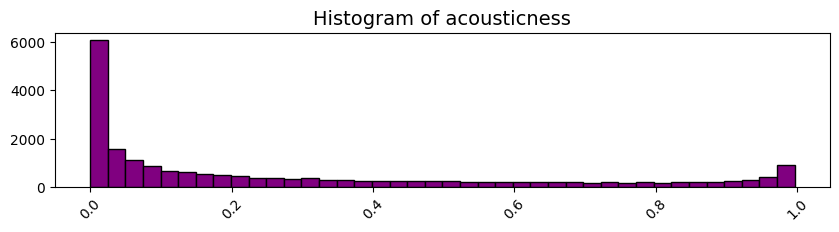

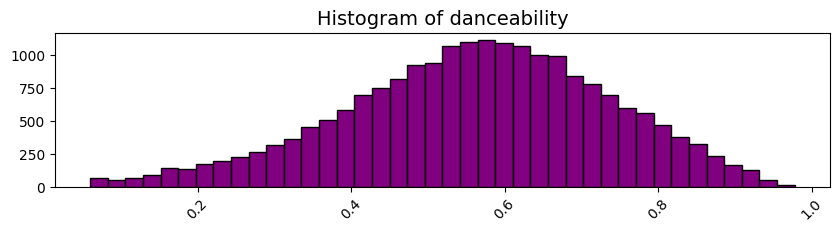

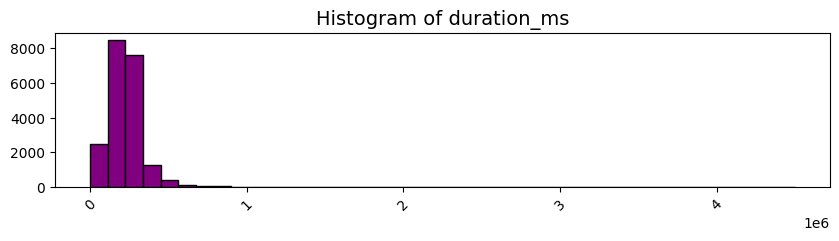

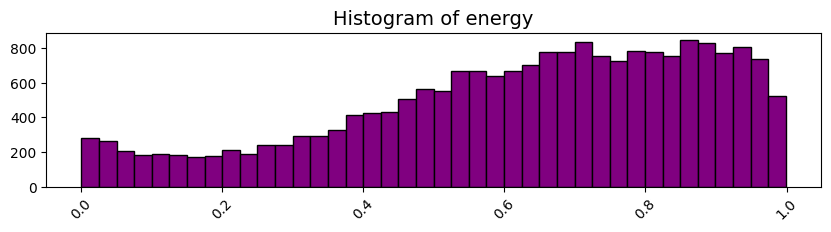

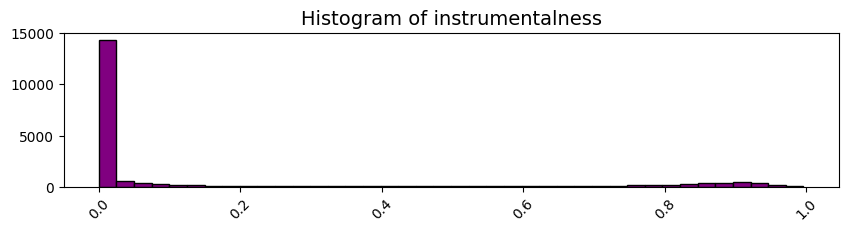

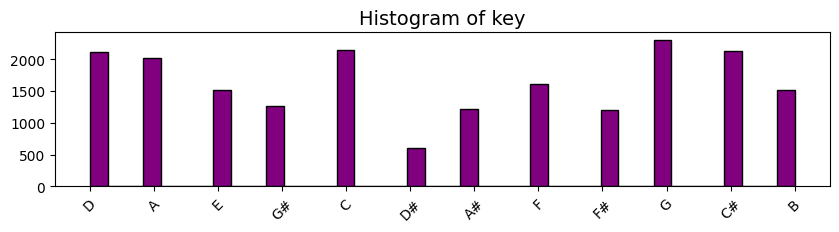

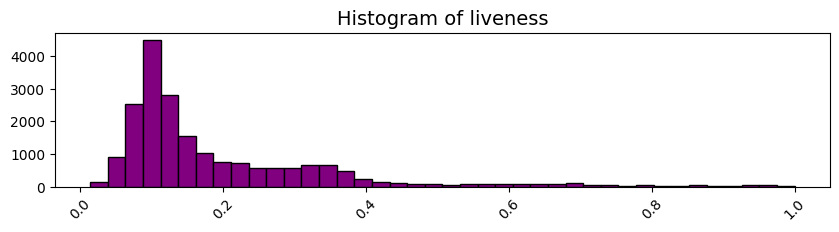

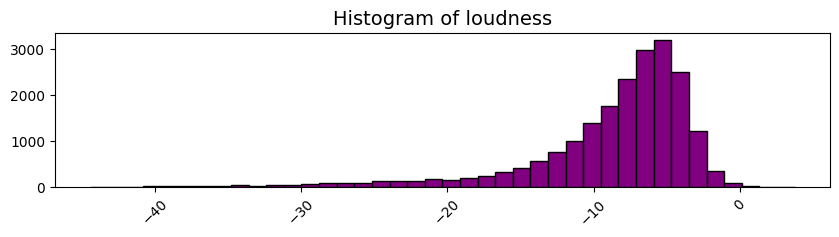

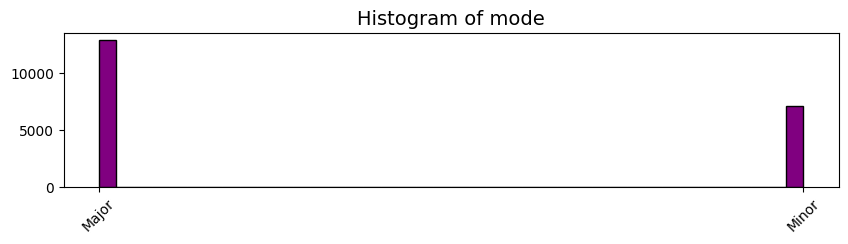

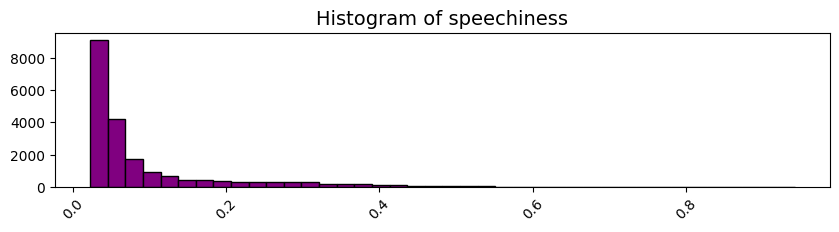

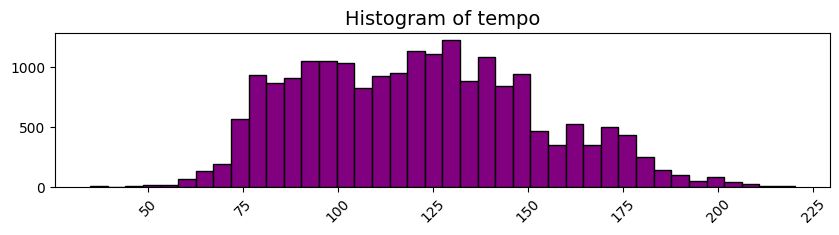

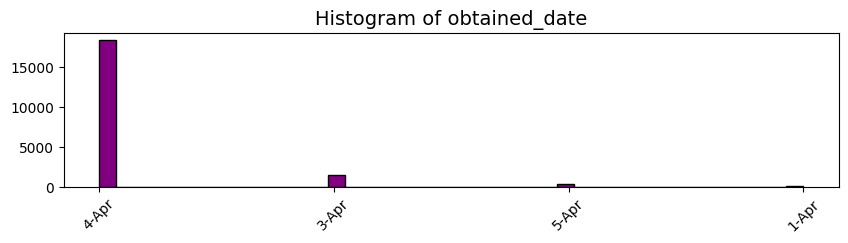

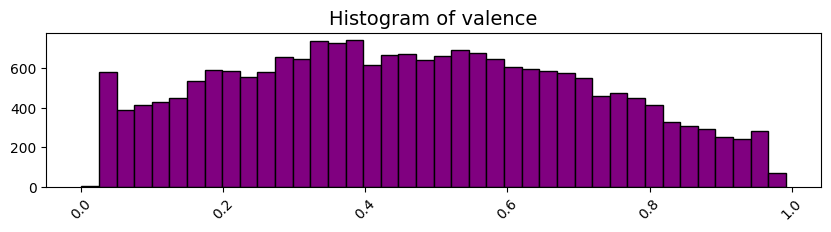

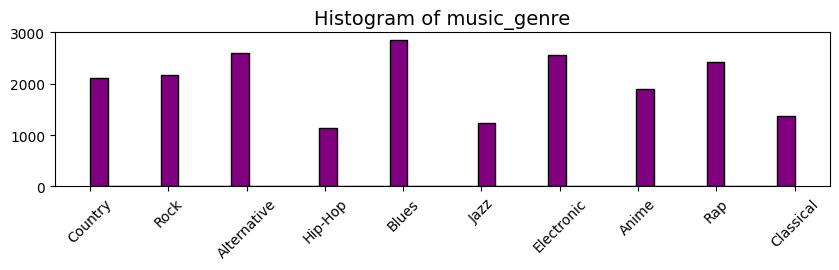

In [20]:
for column in data_train.columns:
    plt.figure(figsize=(10, 2))
    data_train[column].hist(bins = 40, color='purple', edgecolor='black', grid=False)
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

**Короткие выводы по графикам:**

1. Большая часть треков не акустическая
2. Большая часть треков имеет среднюю танцевальность
3. Большая часть треков короче 5*10^6 мс
4. Наблюдается рост кол-ва треков от их энергичности
5. Подавляющее количество треков имеет вокал
6. Тональность треков в целом нормально распределена по всем нотам, просадки диезам и F тональностям.
7. Большая часть треков исполнялась не в живую
8. Большая часть треков по громкости находятся между -10 и 0 дцб
9. Примерно 2/1 распределение модальности треков
10. Большая часть треков является песнями
11. Большая часть треков имеет темп от 75 до 175 бпм
12. Подавляющее число треков было загружено 4 апр
13. В челом треки по настроению распределены номально. В среднем состоянии настроения наблюдается пик (или около того), однако выбивается большое кол-во треков очень грустных
14. По жанрам: мало треков типа джаз, хип-хоп и классика. Больше всего блюза

In [21]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20394 non-null  float64
 1   danceability      20394 non-null  float64
 2   duration_ms       20394 non-null  float64
 3   energy            20394 non-null  float64
 4   instrumentalness  20394 non-null  float64
 5   key               19659 non-null  object 
 6   liveness          20394 non-null  float64
 7   loudness          20394 non-null  float64
 8   mode              19888 non-null  object 
 9   speechiness       20394 non-null  float64
 10  tempo             19952 non-null  float64
 11  obtained_date     20394 non-null  object 
 12  valence           20394 non-null  float64
 13  music_genre       20394 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.2+ MB


Оставшиеся столбцы несут в себе полезную инофрмацию, когорую можно проанализировать посредством МЛ, однаков в некоторых столбцах имеются пропуски. Я буду заполнять пропуски посредством машинного обучения.

In [22]:
phik_overview_data_train = data_train.phik_matrix()
phik_overview_data_train.round(2)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
acousticness,1.00,0.46,0.13,0.77,0.44,0.10,0.19,0.71,0.03,0.20,0.34,0.26,0.40,0.66
danceability,0.46,1.00,0.17,0.52,0.34,0.10,0.14,0.48,0.10,0.34,0.41,0.29,0.53,0.62
duration_ms,0.13,0.17,1.00,0.14,0.17,0.04,0.09,0.17,0.01,0.04,0.08,0.04,0.14,0.20
energy,0.77,0.52,0.14,1.00,0.44,0.09,0.26,0.84,0.03,0.24,0.39,0.29,0.48,0.67
instrumentalness,0.44,0.34,0.17,0.44,1.00,0.03,0.14,0.50,0.08,0.19,0.22,0.13,0.36,0.57
key,0.10,0.10,0.04,0.09,0.03,1.00,0.06,0.08,0.36,0.12,0.04,0.07,0.04,0.17
liveness,0.19,0.14,0.09,0.26,0.14,0.06,1.00,0.20,0.03,0.14,0.08,0.04,0.13,0.21
loudness,0.71,0.48,0.17,0.84,0.50,0.08,0.20,1.00,0.02,0.21,0.36,0.25,0.44,0.68
mode,0.03,0.10,0.01,0.03,0.08,0.36,0.03,0.02,1.00,0.10,0.01,0.06,0.06,0.30
speechiness,0.20,0.34,0.04,0.24,0.19,0.12,0.14,0.21,0.10,1.00,0.21,0.11,0.12,0.50


Я хочу для каждого столбца, имеющего пропуски, посчитать суммарную корреляцию с остальными признаками. значения будут выстроены в порядке убывания, и в этом же порядке будут обрабатываться столбцы.

In [23]:
data_train.isna().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [24]:
data_test.isna().sum()

acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64

In [25]:
list_nan_columns = ['key', 'mode', 'tempo']

Пропуски только в этих столбцах, для них расчитаем корреляции

In [26]:
correlation_sum = []

In [27]:
for column in list_nan_columns:
    sum = 0
    for row in list_nan_columns:
        sum = sum + phik_overview_data_train.loc[column, row]
    correlation_sum.append(sum)

In [28]:
correlation_sum 

[1.4006434339831257, 1.3756658511194408, 1.053544454855399]

В этом же порядке будем обрабатывать пропуски: ['key', 'mode', 'tempo']

In [29]:
def fill_the_gaps(data, parameter):

    num_col = []
    cat_col = []

    train = data.dropna(subset=[parameter]).copy()
    test = data[data[parameter].isna()].copy()

    y_train = train[parameter]

    X_train = train.drop(parameter, axis = 1)

    X_test = test.drop(parameter, axis = 1)

    for column in data.columns:
        if data[column].dtype == 'float64':
            num_col.append(column)
        else:
            cat_col.append(column)
    
    if parameter in cat_col:
        cat_check = True
    else:
        cat_check = False
    
    try:
        cat_col.remove(parameter)
    except:
        num_col.remove(parameter)
        
    num_transformer = make_pipeline(num_imputer, scaler)
    cat_transformer = make_pipeline(cat_imputer, onehotencoder)

    preprocessor = ColumnTransformer(
          transformers=[('num', num_transformer, num_col),
                        ('cat', cat_transformer, cat_col)])

    if cat_check == True:
        model_logistic = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=1000)
        pipe = make_pipeline(preprocessor, model_logistic)
    else:
        model_linear = LinearRegression()
        pipe = make_pipeline(preprocessor, model_linear)

    pipe.fit(X_train, y_train)

    y_test = pipe.predict(X_test)
    
    test[parameter] = y_test
    
    data = pd.concat([train, test])
    
    data.sort_index(inplace = True)
    
    return data

In [30]:
def rework_data(data):
    for param in list_nan_columns:
        data = fill_the_gaps(data, param)
    return data

In [31]:
data_train_rework = data_train.copy()

In [32]:
data_train_rework = rework_data(data_train_rework)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [33]:
data_train_rework.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

От всех пропущенных значений получилось избавиться

In [34]:
data_train_rework.loc[data_train_rework['duration_ms'] < 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
13,0.11000,0.470,-1.0,0.6410,0.000000,F#,0.1550,-7.454,Major,0.0658,86.387,4-Apr,0.6380,Anime
26,0.99100,0.154,-1.0,0.0384,0.902000,D,0.1090,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
35,0.08480,0.748,-1.0,0.7120,0.000000,D,0.1320,-5.651,Major,0.1430,140.055,4-Apr,0.1800,Rap
50,0.05400,0.482,-1.0,0.6270,0.000003,D,0.1110,-5.779,Major,0.0300,95.903,4-Apr,0.1700,Alternative
55,0.90900,0.374,-1.0,0.2270,0.000069,A#,0.6860,-18.719,Major,0.0579,78.236,4-Apr,0.2640,Classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20353,0.00298,0.450,-1.0,0.9150,0.446000,F,0.7710,-1.404,Minor,0.2360,137.948,4-Apr,0.1560,Electronic
20357,0.98200,0.372,-1.0,0.1590,0.000001,G,0.1650,-21.129,Major,0.0364,135.617,3-Apr,0.5120,Classical
20358,0.96600,0.638,-1.0,0.0689,0.000001,E,0.1020,-16.222,Major,0.0659,120.160,3-Apr,0.6950,Blues
20366,0.62700,0.461,-1.0,0.4360,0.892000,G,0.1330,-9.381,Major,0.0301,130.035,4-Apr,0.2640,Anime


Есть строки с отрицательной длиной трека

In [35]:
data_train_rework.loc[data_train_rework['duration_ms'] < 0, 'duration_ms'].count() / data_train_rework['duration_ms'].count()

0.09850936549965676

Таких строк много, их составляет ~9%
Попробую их также заменить при помощи мл.

In [36]:
def fill_the_minus(data, parameter):

    num_col = []
    cat_col = []

    train = data.loc[data[parameter] > 0].copy()
    test = data.loc[data[parameter] <= 0].copy()

    y_train = train[parameter]

    X_train = train.drop(parameter, axis = 1)

    X_test = test.drop(parameter, axis = 1)
    
    for column in data.columns:
        if data[column].dtype == 'float64':
            num_col.append(column)
        else:
            cat_col.append(column)
    
    if parameter in cat_col:
        cat_check = True
    else:
        cat_check = False
    
    try:
        cat_col.remove(parameter)
    except:
        num_col.remove(parameter)
        
    num_transformer = make_pipeline(num_imputer, scaler)
    cat_transformer = make_pipeline(cat_imputer, onehotencoder)

    preprocessor = ColumnTransformer(
          transformers=[('num', num_transformer, num_col),
                        ('cat', cat_transformer, cat_col)])

    if cat_check == True:
        model_logistic = LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs', max_iter=1000)
        pipe = make_pipeline(preprocessor, model_logistic)
    else:
        model_linear = LinearRegression()
        pipe = make_pipeline(preprocessor, model_linear)

    pipe.fit(X_train, y_train)

    y_test = pipe.predict(X_test)
    
    test[parameter] = y_test
    
    data = pd.concat([train, test])
    
    data.sort_index(inplace = True)
    
    return data

In [37]:
data_train_rework = fill_the_minus(data_train_rework, 'duration_ms')

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
data_train_rework.loc[data_train_rework['duration_ms'] < 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre


Больше таких строк нет

In [39]:
data_test_rework = data_test.copy()

In [40]:
data_test_rework.loc[data_test_rework['duration_ms'] < 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
4,0.000335,0.421,-1.0,0.4470,0.014800,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121
22,0.000031,0.541,-1.0,0.9910,0.068200,F,0.8550,-5.255,Major,0.0479,140.092,4-Apr,0.839
26,0.150000,0.725,-1.0,0.5520,0.000000,B,0.2140,-7.369,Minor,0.0475,111.996,4-Apr,0.582
36,0.674000,0.746,-1.0,0.3380,0.000375,B,0.5290,-13.472,Minor,0.1090,120.053,4-Apr,0.469
43,0.069800,0.564,-1.0,0.7340,0.000000,G#,0.1570,-5.676,Major,0.0350,140.053,4-Apr,0.536
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5054,0.925000,0.484,-1.0,0.0697,0.000000,C#,0.5260,-28.395,Minor,0.0518,101.668,3-Apr,0.471
5064,0.945000,0.487,-1.0,0.3060,0.721000,G,0.1020,-13.161,NaN,0.0390,109.974,4-Apr,0.164
5065,0.259000,0.799,-1.0,0.5950,0.000000,D,0.3440,-7.015,Major,0.1930,120.060,4-Apr,0.555
5071,0.095900,0.829,-1.0,0.8780,0.000000,A,0.7760,-5.951,Major,0.1010,87.991,4-Apr,0.883


В тетсовом датафрейме аналогичные проблемы, переходим к заполнению пропусков

In [41]:
data_test_rework = rework_data(data_test_rework)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
data_test_rework.isna().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
dtype: int64

Пропуски устранены

In [43]:
data_test_rework = fill_the_minus(data_test_rework, 'duration_ms')

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [44]:
data_test_rework.loc[data_test_rework['duration_ms'] < 0]

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence


Больше таких строк нет

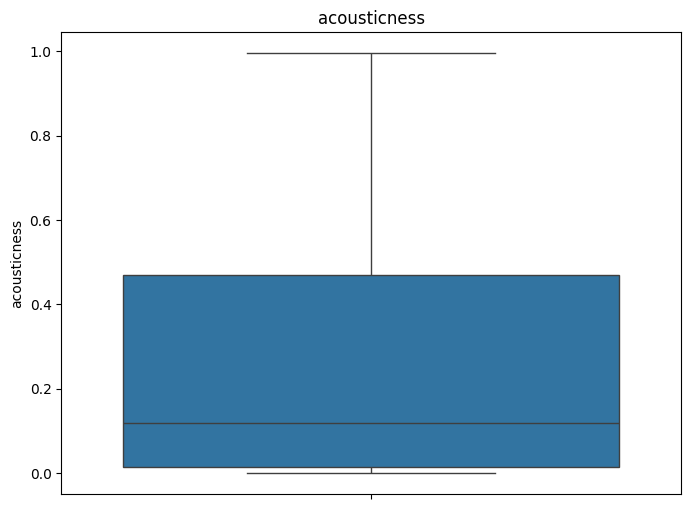

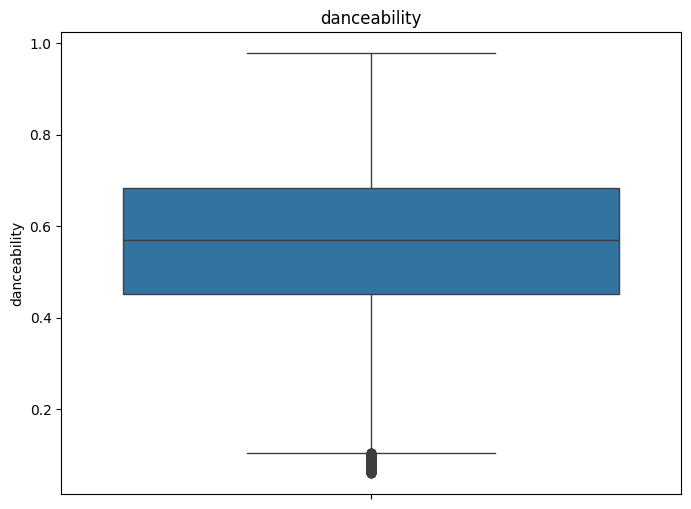

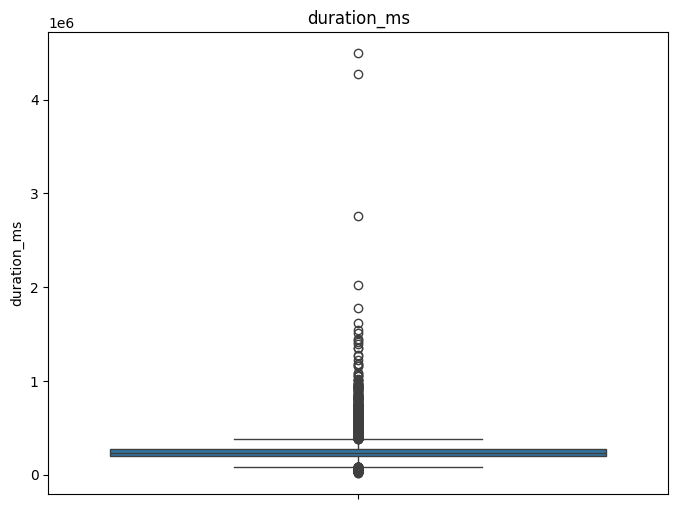

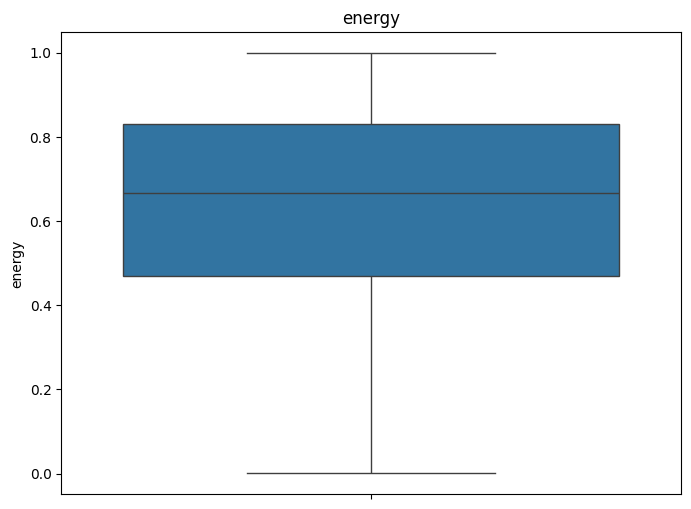

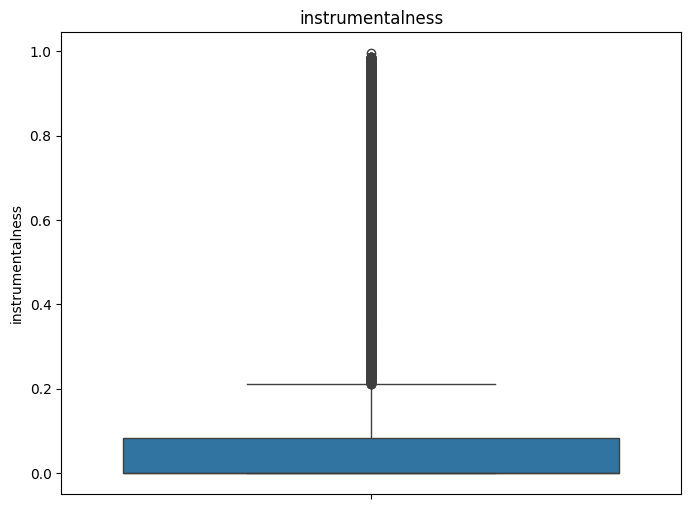

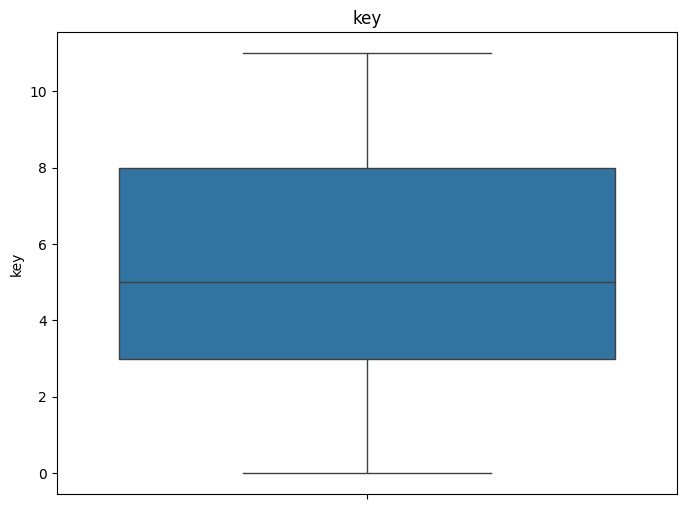

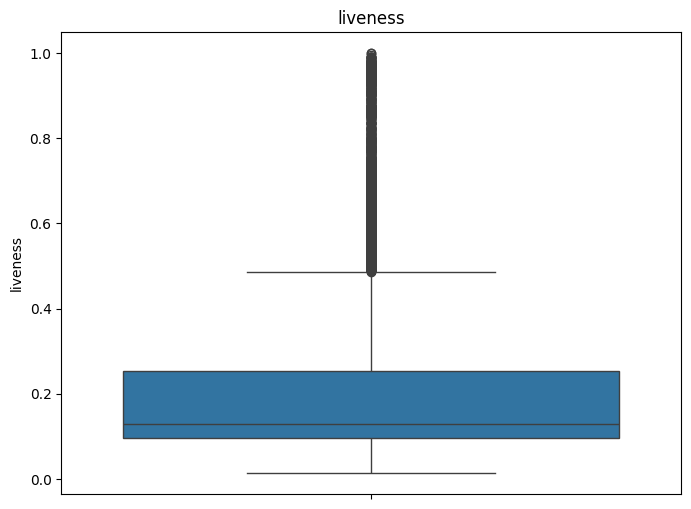

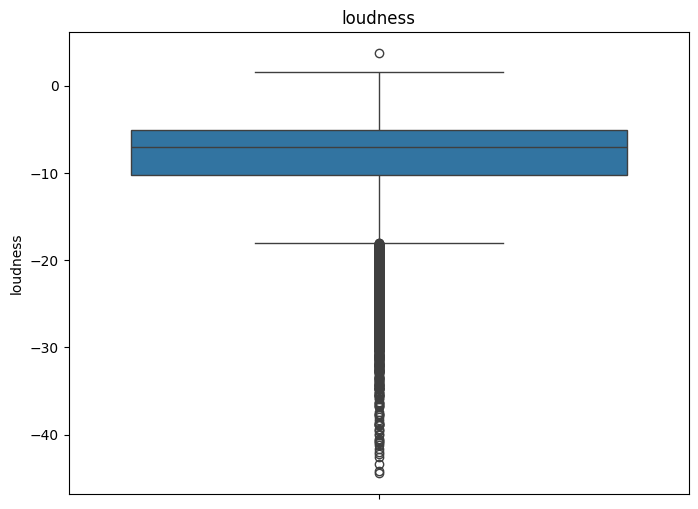

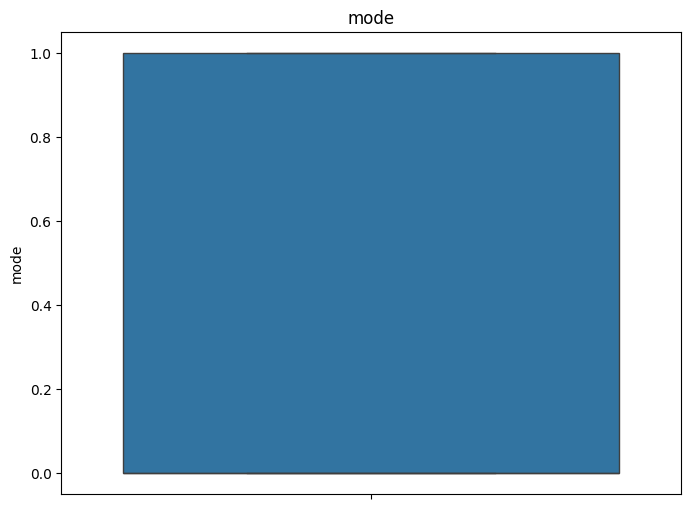

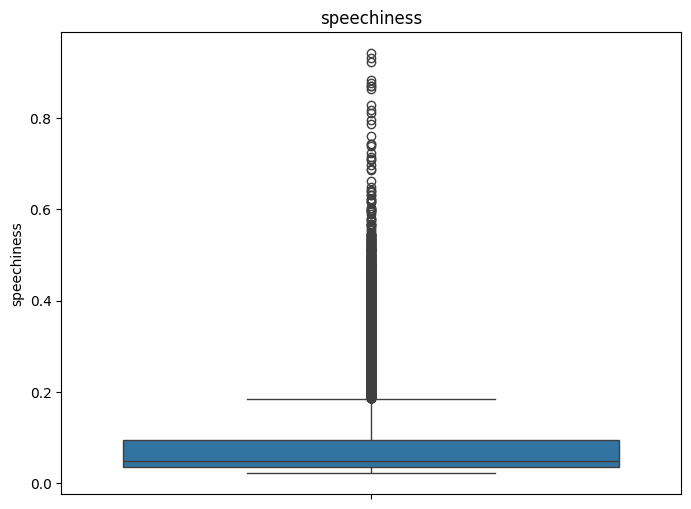

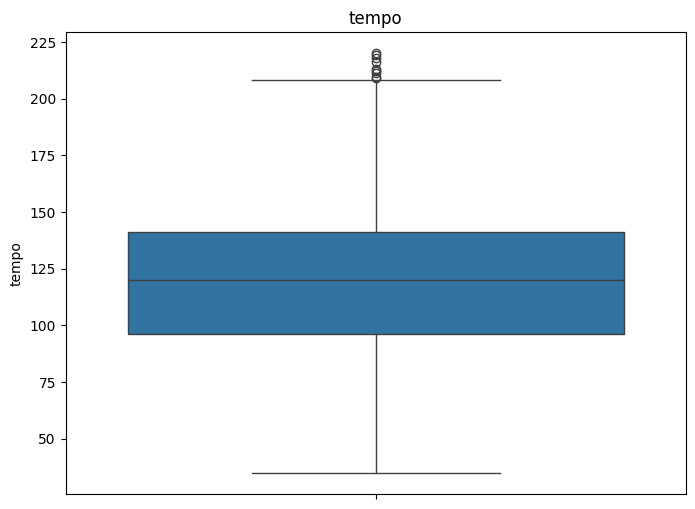

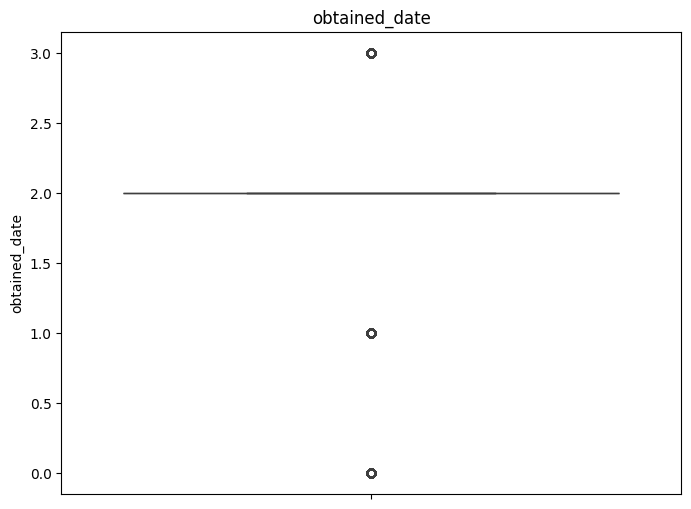

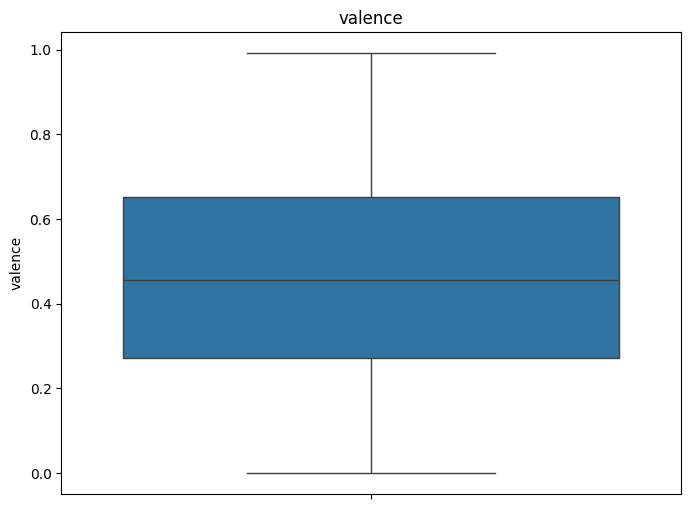

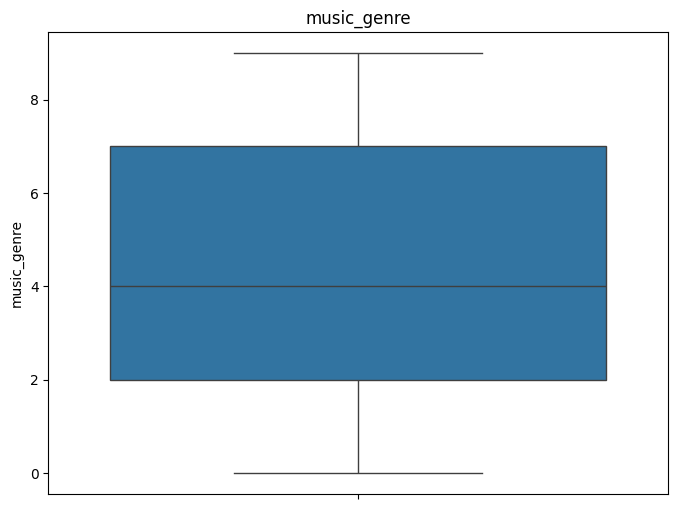

In [45]:
data_train_encoded = data_train_rework.copy()

label_encoder = LabelEncoder()
for column in data_train_encoded.columns:
    if data_train_encoded[column].dtype == 'object':
        data_train_encoded[column] = label_encoder.fit_transform(data_train_encoded[column])

for column in data_train_encoded.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data_train_encoded[column])
    plt.title(column)
    plt.show()

Как видно, естьпризнеаки, значения которых выбиваются из доверительного интервала. Я замению из на медианные значения сгруппированого признака жанра

In [46]:
def replace_outliers_with_median(df):
    new_df = df.copy()
    label_encoders = {}
    
    for column in df.columns:
        if new_df[column].dtype == 'object':
            label_encoder = LabelEncoder()
            new_df[column] = label_encoder.fit_transform(new_df[column])
            label_encoders[column] = label_encoder

        Q1 = new_df[column].quantile(0.25)
        Q3 = new_df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        new_df[column] = new_df.groupby('music_genre')[column].transform(lambda x: x.mask((x < lower_bound) | (x > upper_bound), x.median()))
    
    for column, label_encoder in label_encoders.items():
        new_df[column] = label_encoder.inverse_transform(new_df[column])

    return new_df

In [47]:
data_train_rework_clean = data_train_rework

In [48]:
new_data_train_rework_clean = replace_outliers_with_median(data_train_rework_clean)

In [49]:
data_train_rework_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20394 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20394 non-null  float64
 1   danceability      20394 non-null  float64
 2   duration_ms       20394 non-null  float64
 3   energy            20394 non-null  float64
 4   instrumentalness  20394 non-null  float64
 5   key               20394 non-null  object 
 6   liveness          20394 non-null  float64
 7   loudness          20394 non-null  float64
 8   mode              20394 non-null  object 
 9   speechiness       20394 non-null  float64
 10  tempo             20394 non-null  float64
 11  obtained_date     20394 non-null  object 
 12  valence           20394 non-null  float64
 13  music_genre       20394 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


In [50]:
new_data_train_rework_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20394 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20394 non-null  float64
 1   danceability      20394 non-null  float64
 2   duration_ms       20394 non-null  float64
 3   energy            20394 non-null  float64
 4   instrumentalness  20394 non-null  float64
 5   key               20394 non-null  object 
 6   liveness          20394 non-null  float64
 7   loudness          20394 non-null  float64
 8   mode              20394 non-null  object 
 9   speechiness       20394 non-null  float64
 10  tempo             20394 non-null  float64
 11  obtained_date     20394 non-null  object 
 12  valence           20394 non-null  float64
 13  music_genre       20394 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


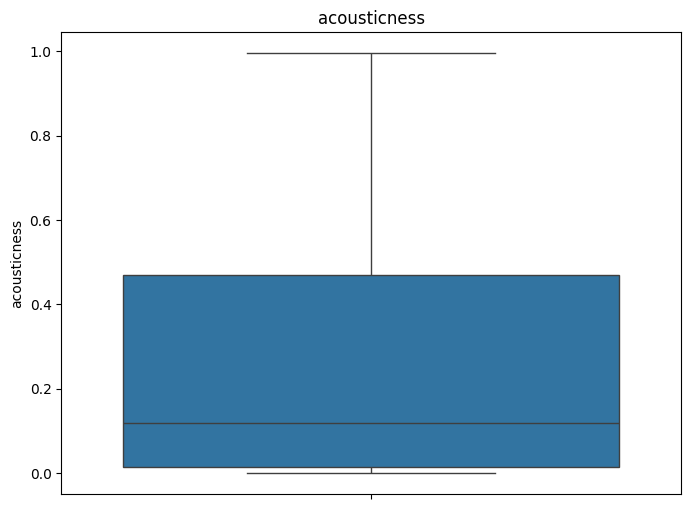

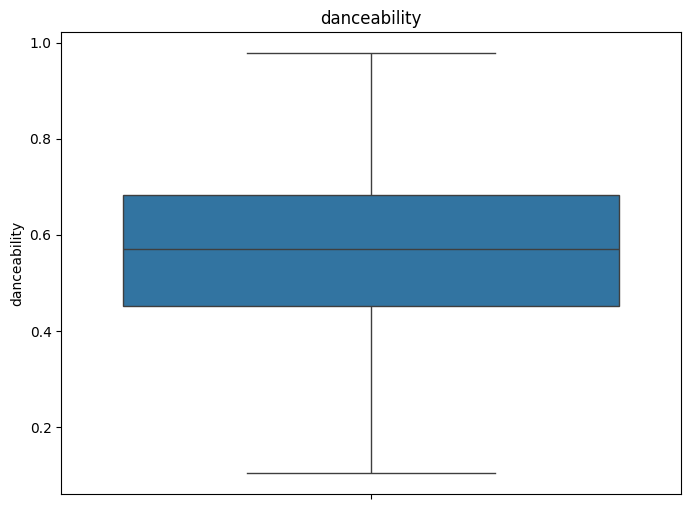

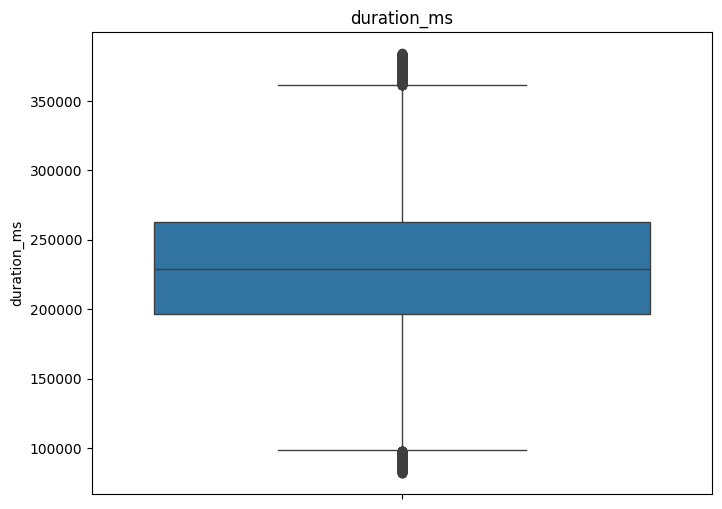

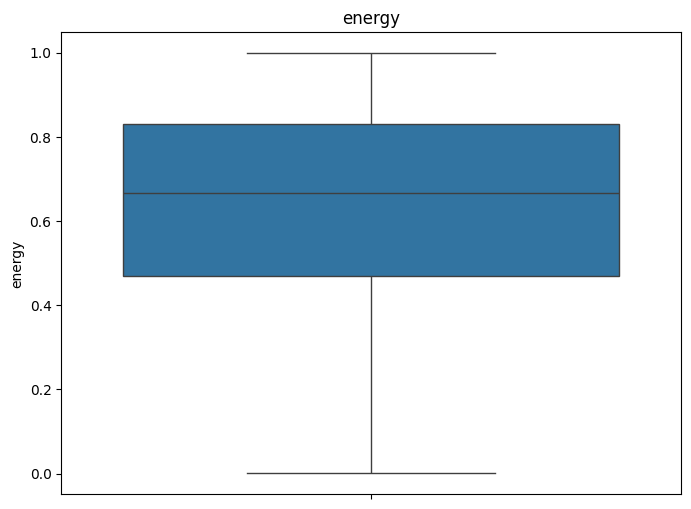

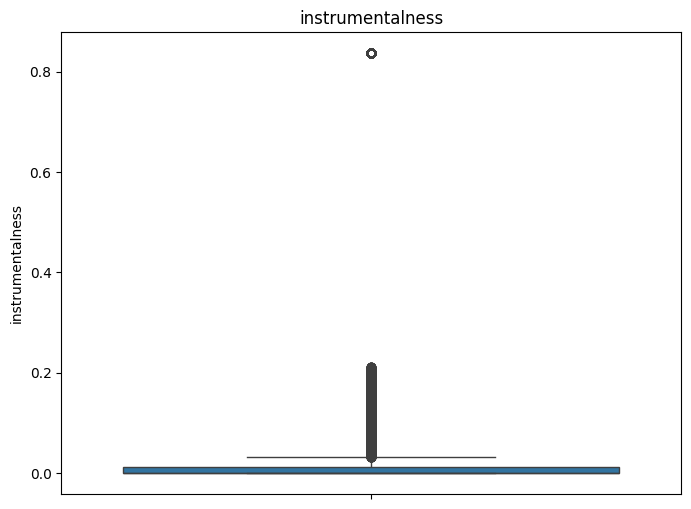

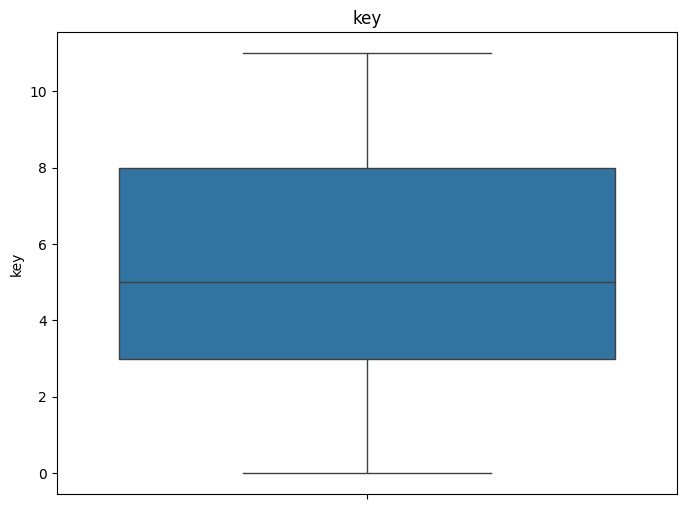

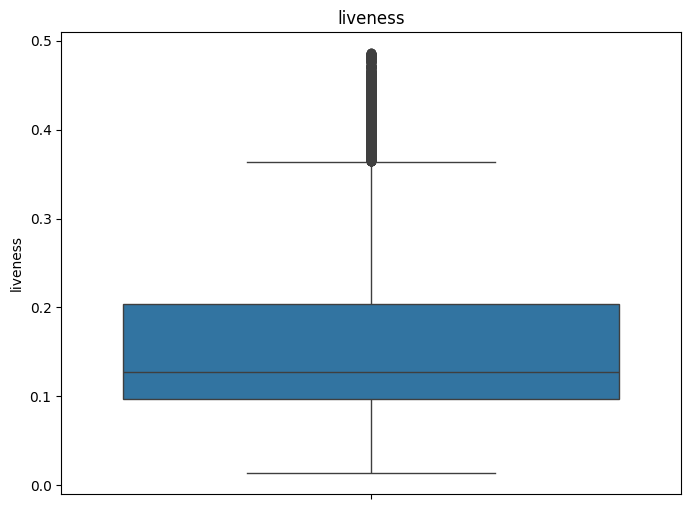

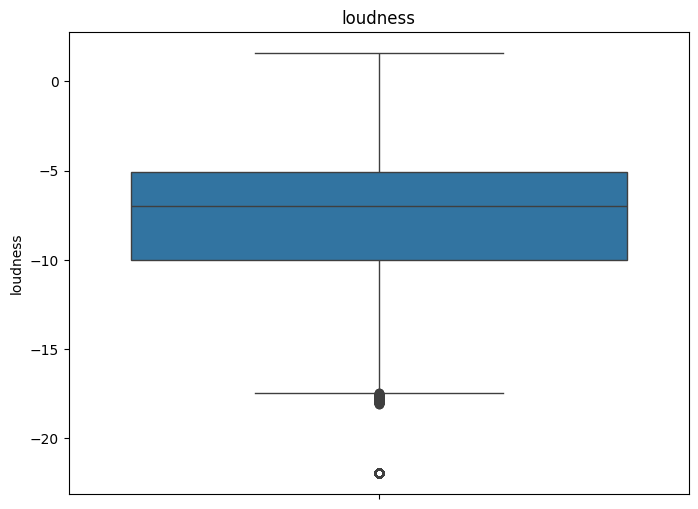

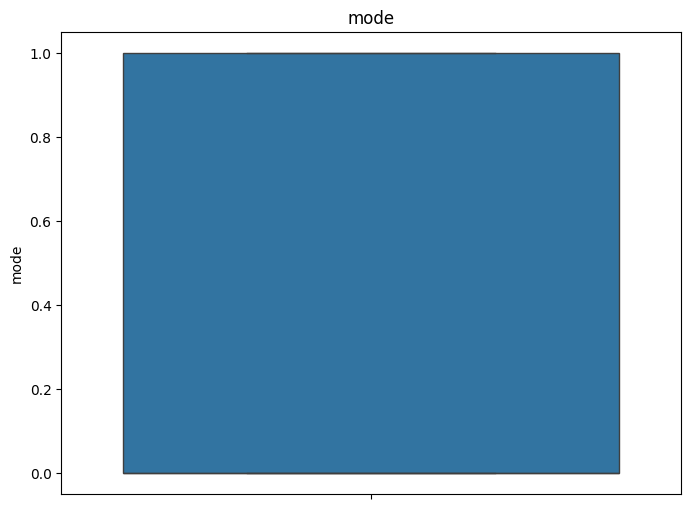

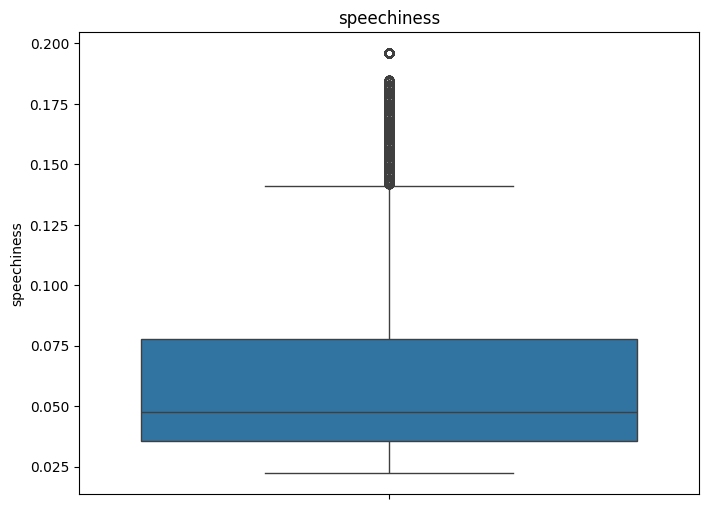

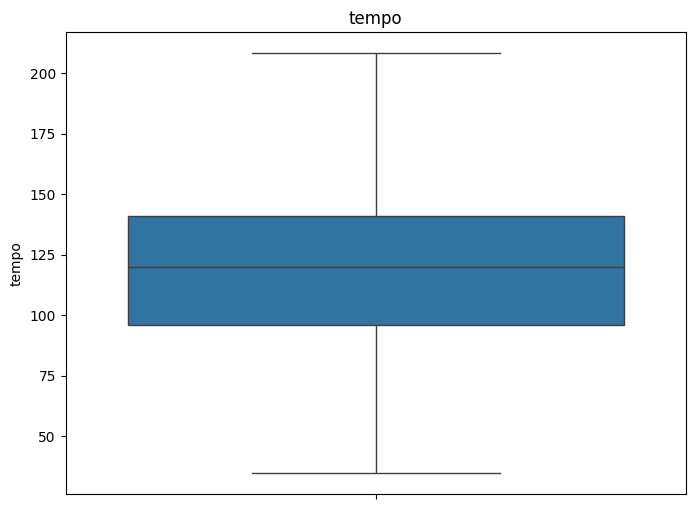

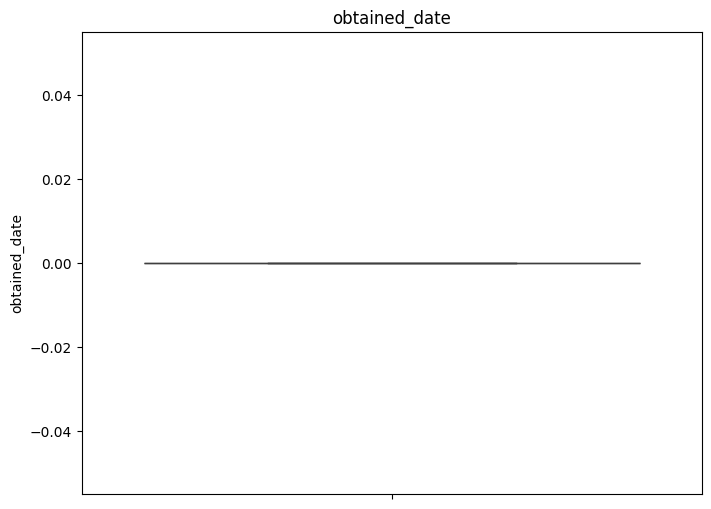

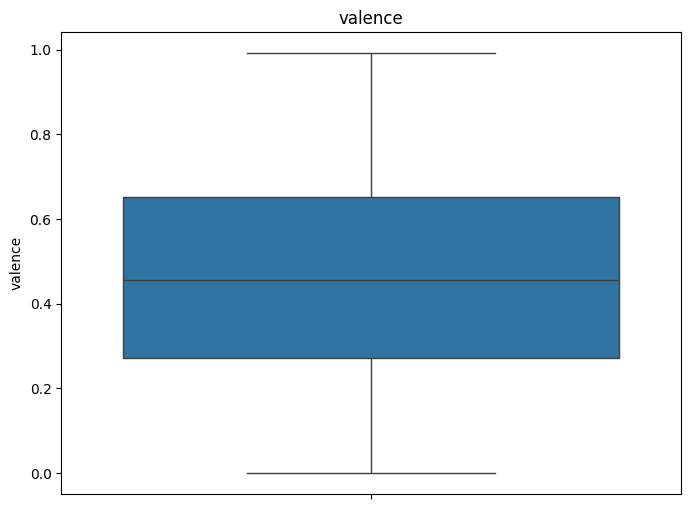

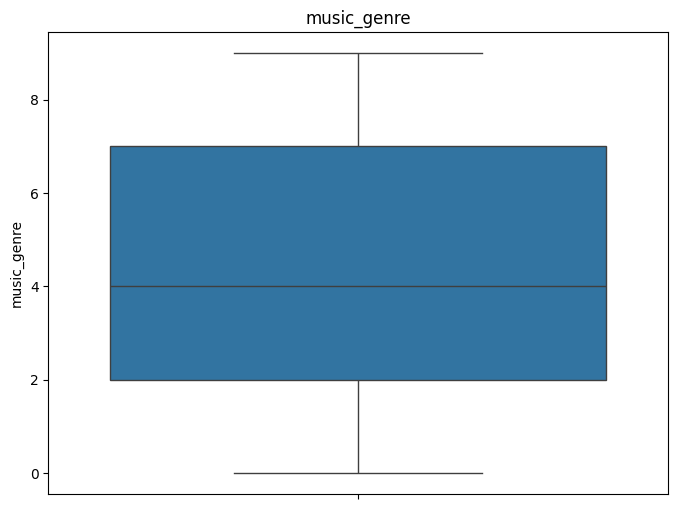

In [51]:
new_data_train_rework_clean_encoded = new_data_train_rework_clean.copy()

label_encoder = LabelEncoder()
for column in new_data_train_rework_clean_encoded.columns:
    if new_data_train_rework_clean_encoded[column].dtype == 'object':
        new_data_train_rework_clean_encoded[column] = label_encoder.fit_transform(new_data_train_rework_clean_encoded[column])

for column in new_data_train_rework_clean_encoded.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=new_data_train_rework_clean_encoded[column])
    plt.title(column)
    plt.show()

In [52]:
data_train_rework_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20394 entries, 0 to 20393
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      20394 non-null  float64
 1   danceability      20394 non-null  float64
 2   duration_ms       20394 non-null  float64
 3   energy            20394 non-null  float64
 4   instrumentalness  20394 non-null  float64
 5   key               20394 non-null  object 
 6   liveness          20394 non-null  float64
 7   loudness          20394 non-null  float64
 8   mode              20394 non-null  object 
 9   speechiness       20394 non-null  float64
 10  tempo             20394 non-null  float64
 11  obtained_date     20394 non-null  object 
 12  valence           20394 non-null  float64
 13  music_genre       20394 non-null  object 
dtypes: float64(10), object(4)
memory usage: 2.3+ MB


In [111]:
new_data_train_rework_clean = new_data_train_rework_clean.drop('obtained_date', axis = 1)

In [112]:
new_data_train_rework_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20394 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   acousticness      20394 non-null  float64 
 1   danceability      20394 non-null  float64 
 2   duration_ms       20394 non-null  float64 
 3   energy            20394 non-null  float64 
 4   instrumentalness  20394 non-null  float64 
 5   key               20394 non-null  category
 6   liveness          20394 non-null  float64 
 7   loudness          20394 non-null  float64 
 8   mode              20394 non-null  category
 9   speechiness       20394 non-null  float64 
 10  tempo             20394 non-null  float64 
 11  valence           20394 non-null  float64 
 12  music_genre       20394 non-null  category
dtypes: category(3), float64(10)
memory usage: 2.3 MB


In [113]:
data_test_rework = data_test_rework.drop('obtained_date', axis = 1)

KeyError: "['obtained_date'] not found in axis"

In [114]:
data_test_rework.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5099 entries, 0 to 5098
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   acousticness      5099 non-null   float64 
 1   danceability      5099 non-null   float64 
 2   duration_ms       5099 non-null   float64 
 3   energy            5099 non-null   float64 
 4   instrumentalness  5099 non-null   float64 
 5   key               5099 non-null   category
 6   liveness          5099 non-null   float64 
 7   loudness          5099 non-null   float64 
 8   mode              5099 non-null   category
 9   speechiness       5099 non-null   float64 
 10  tempo             5099 non-null   float64 
 11  valence           5099 non-null   float64 
dtypes: category(2), float64(10)
memory usage: 448.7 KB


Значения поправлены

# **3. Подготовка модели**

Разделение выборки:

In [194]:
categorical_features = new_data_train_rework_clean.select_dtypes(include=['object']).columns
print(categorical_features)

new_data_train_rework_clean[categorical_features] = new_data_train_rework_clean[categorical_features].astype('category')
print(new_data_train_rework_clean.info())

Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 20394 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   acousticness      20394 non-null  float64 
 1   danceability      20394 non-null  float64 
 2   duration_ms       20394 non-null  float64 
 3   energy            20394 non-null  float64 
 4   instrumentalness  20394 non-null  float64 
 5   key               20394 non-null  category
 6   liveness          20394 non-null  float64 
 7   loudness          20394 non-null  float64 
 8   mode              20394 non-null  category
 9   speechiness       20394 non-null  float64 
 10  tempo             20394 non-null  float64 
 11  valence           20394 non-null  float64 
 12  music_genre       20394 non-null  category
dtypes: category(3), float64(10)
memory usage: 2.3 MB
None


In [195]:
X = new_data_train_rework_clean.drop('music_genre', axis = 1).copy()
y = new_data_train_rework_clean['music_genre'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

Попробую сразу организовать пайплайны

In [196]:
column_transformer_solver = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), make_column_selector(dtype_include='number')),
        ('categorical', onehotencoder, make_column_selector(dtype_include='category'))
    ],
    remainder='passthrough'
)

In [198]:
model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

pipe_solver = Pipeline([
    ('preprocessor', column_transformer_solver),  
    ('model', model) ])

In [199]:
pipe_solver.fit(X_train, y_train)

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e9bc17fa5f0>),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e9bc17f9d20>)])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7e9bc1f13eb0>)])

In [200]:
y_pred = pipe_solver.predict(X_test)
f1_micro = f1_score(y_test, y_pred, average='micro')
print(f"F1 Score: {f1_micro}")

F1 Score: 0.6295352029809766


In [213]:
y_pred

array([[4],
       [7],
       [1],
       ...,
       [8],
       [8],
       [0]])

In [219]:
decoded_labels = label_encoder.inverse_transform(y_pred)
decoded_labels

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Country', 'Jazz', 'Anime', ..., 'Rap', 'Rap', 'Alternative'],
      dtype=object)

In [216]:
decoded_values

<function sklearn.preprocessing._encoders.OneHotEncoder.inverse_transform(self, X)>

In [152]:
print(f"F1 Score: {f1_micro}")

F1 Score: 0.6311041380662875


Хорошее значение! жалко я не успел загрузить в кагл :)

In [104]:
cross_val_results = cross_val_score(pipe_solver, X, y, cv=5, scoring='f1_micro')

print(f'Средняя F1 Micro кросс-валидации: {cross_val_results.mean()}')
print(f'Стандартное отклонение F1 Micro кросс-валидации: {cross_val_results.std()}')

Средняя F1 Micro кросс-валидации: 0.6202805287095317
Стандартное отклонение F1 Micro кросс-валидации: 0.007067428722013971


Кроссвалидация также показала хорошие значения

In [61]:
params = {
    'catboostclassifier__iterations': [50, 100, 200],
    'catboostclassifier__depth': [3, 5, 10],
    'catboostclassifier__l2_leaf_reg': [1, 3, 5],
    'catboostclassifier__subsample': [0.8, 1.0],
    'catboostclassifier__colsample_bylevel': [0.8, 1.0],
    'catboostclassifier__border_count': [32, 64, 128],
    'catboostclassifier__bootstrap_type': ['Bernoulli', 'MVS']
}


Некоторые параметры для проверки и подбора лучшей модели в grid

In [62]:
#grid = GridSearchCV(pipe_solver, params, cv=5, scoring='f1_micro')
#grid.fit(X_train, y_train)

In [63]:
#grid.best_estimator_

In [64]:
#grid.cv_results_

In [65]:
#pd.DataFrame(grid.cv_results_).head()

In [66]:
#best_params = grid.best_params_
#best_f1_score = grid.best_score_
#best_model = grid.best_estimator_


#print("Best Parameters:", best_params)
#print("Best F1 Score:", best_f1_score)

Тут я все закомментил, все ооочень долго считалось, но гипперпараметры лучшей модели я загрузил ниже

In [79]:
best_of_the_best_model = CatBoostClassifier(bootstrap_type = 'MVS', border_count = 64, colsample_bylevel = 1, depth = 10, iterations = 200, l2_leaf_reg = 1, subsample = 0.8, verbose=False)

In [80]:
best_pipe_solver = make_pipeline(column_transformer_solver, best_of_the_best_model)

In [81]:
best_pipe_solver.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e9e2f132ad0>),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e9e2f132410>)])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7e9e2ea13220>)])

In [82]:
y_pred_best = best_pipe_solver.predict(X_test)
f1_micro = f1_score(y_test, y_pred_best, average='micro')
print(f"F1 Score: {f1_micro}")

F1 Score: 0.6020788389880368


In [83]:
cross_val_results_best = cross_val_score(best_pipe_solver, X, y, cv=5, scoring='f1_micro')

In [121]:
print(f'Средняя F1 Micro кросс-валидации: {cross_val_results_best.mean()}')
print(f'Стандартное отклонение F1 Micro кросс-валидации: {cross_val_results_best.std()}')

Средняя F1 Micro кросс-валидации: 0.5901244799707974
Стандартное отклонение F1 Micro кросс-валидации: 0.004833051184398579


По какой-то причине значения получились хуже. Видимо, я еще плохо подбираю гипперпараметры :)

In [122]:
data_test_rework.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5099 entries, 0 to 5098
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   acousticness      5099 non-null   float64 
 1   danceability      5099 non-null   float64 
 2   duration_ms       5099 non-null   float64 
 3   energy            5099 non-null   float64 
 4   instrumentalness  5099 non-null   float64 
 5   key               5099 non-null   category
 6   liveness          5099 non-null   float64 
 7   loudness          5099 non-null   float64 
 8   mode              5099 non-null   category
 9   speechiness       5099 non-null   float64 
 10  tempo             5099 non-null   float64 
 11  valence           5099 non-null   float64 
dtypes: category(2), float64(10)
memory usage: 448.7 KB


In [153]:
categorical_features = data_test_rework.select_dtypes(include=['object']).columns
print(categorical_features)

data_test_rework[categorical_features] = data_test_rework[categorical_features].astype('category')
print(data_test_rework.info())

Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 5099 entries, 0 to 5098
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   acousticness      5099 non-null   float64 
 1   danceability      5099 non-null   float64 
 2   duration_ms       5099 non-null   float64 
 3   energy            5099 non-null   float64 
 4   instrumentalness  5099 non-null   float64 
 5   key               5099 non-null   category
 6   liveness          5099 non-null   float64 
 7   loudness          5099 non-null   float64 
 8   mode              5099 non-null   category
 9   speechiness       5099 non-null   float64 
 10  tempo             5099 non-null   float64 
 11  valence           5099 non-null   float64 
dtypes: category(2), float64(10)
memory usage: 448.7 KB
None


In [204]:
y_data_test_rework = pipe_solver.predict(data_test_rework)

Предсказываем значения для тестового дф

In [220]:
y_data_test_rework

array([[6],
       [9],
       [6],
       ...,
       [6],
       [5],
       [7]])

In [222]:
decoded_labels = label_encoder.inverse_transform(y_data_test_rework)
decoded_labels

/usr/local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['Hip-Hop', 'Rock', 'Hip-Hop', ..., 'Hip-Hop', 'Electronic', 'Jazz'],
      dtype=object)

Декодирую

In [223]:
df_decoded = pd.DataFrame({'music_genre': decoded_labels})

In [224]:
df_decoded

,music_genre
0,Hip-Hop
1,Rock
2,Hip-Hop
3,Country
4,Hip-Hop
...,...
5094,Country
5095,Rap
5096,Hip-Hop
5097,Electronic


In [230]:
result_df = pd.concat([data_test_raw, df_decoded], axis=1)

Объединяю

In [231]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
 15  music_genre       5099 non-null   object 
dtypes: float64(10), int64(1), object(5)
memory

In [232]:
result_df

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895,Hip-Hop
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318,Rock
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412,Hip-Hop
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614,Country
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121,Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,50532,What We Gonna Do About It,0.108000,0.558,163049.0,0.767,0.00000,E,0.0954,-4.561,Minor,0.0491,158.019,4-Apr,0.715,Country
5095,26255,Marilyn (feat. Dominique Le Jeune),0.131000,0.435,196216.0,0.641,0.00000,A#,0.2730,-7.274,Major,0.1040,115.534,3-Apr,0.156,Rap
5096,67924,Bipolar,0.152000,0.756,243373.0,0.787,0.00000,D,0.2050,-7.423,Major,0.2400,123.405,4-Apr,0.459,Hip-Hop
5097,79778,Dead - NGHTMRE Remix,0.001450,0.489,185600.0,0.974,0.63800,F#,0.1230,-2.857,Minor,0.0381,150.036,4-Apr,0.665,Electronic


In [234]:
finish_df = result_df[['instance_id', 'music_genre']].copy()

In [235]:
finish_df

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Rock
2,88081,Hip-Hop
3,78331,Country
4,72636,Hip-Hop
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Hip-Hop
5097,79778,Electronic


In [240]:
finish_df.to_csv('sample_submit.csv', index=False)
link = FileLink('sample_submit.csv')
link

/kaggle/working/sample_submit.csv

В общем, худо-бедно получилось. Для тестового дф предсказаны значения, файл выгружен 

Немного вресени не хватило, очень жаль :(